In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyhive import presto
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")
import my_func

presto_conn = presto.connect(
    host='bi-presto.serving.data.production.internal',
    port=80,
    protocol='http',
    catalog='hive',
    username='mayank.jha@rapido.bike',
    # requests_kwargs=req_kw,
)

In [24]:
start_date = '2022-02-07'
end_date = '2022-02-13'
city = 'Hyderabad'

In [25]:
# LTR and Activation Date

def get_ltr(start_date, end_date, city):
    print("fetching activated captains data for : ", start_date, " to : ", end_date)
    orders_query = """   select captainId as captain_id,
                                registrationdate, 
                                date(activationdate) as activationdate,
                                lastridedate,
                                lifetimerides as ltr,
                                preferredtimebucket,
                                case when weekdaycaptain = true then 'weekday'
                                     when weekendcaptain = true then 'weekend'
                                     else 'undecided' end as prefferedday
                            from datasets.captain_single_view 
                            where date(activationdate) between date('{sd}') and date('{ed}')
                                and registeredcity = '{ct}'
           
               """.format(sd=start_date, ed= end_date, ct = city)
    
    tmp = pd.read_sql(orders_query, presto_conn)
    print(' fetched LTR & activation date ', len(tmp))

    return tmp

#df_ltr = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list:
    ltr = get_ltr(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city.lower())
    ltr['week'] = pd.to_datetime(day).strftime('%V')
    ltr['week'] = ltr['week'].apply(pd.to_numeric)
    df_ltr = pd.concat([df_ltr, ltr])

print(df_ltr.shape)

fetching activated captains data for :  2022-02-07  to :  2022-02-13
 fetched LTR & activation date  3416
(11954, 8)


In [387]:
start_date = '2022-03-07'
end_date = '2022-03-13'
city = 'Hyderabad'

In [386]:
pd.to_datetime('2022-03-07').strftime('%V')

'10'

In [388]:
# Rides

def get_rides(start_date, end_date, city):
    
    print("fetching rides data for : ", start_date, " to : ", end_date)
    rides_query = """SELECT captain_id,
                            count(distinct order_date) as active_days,
                            sum(case when service_obj_service_name = 'Link' then 1 else 0 end) as link_orders,
                            sum(case when service_obj_service_name in ('Delivery', 'Zomato') then 1 else 0 end) as delivery_orders,
                            count(*) as total_orders,
                            avg(customer_feedback_rating) as customer_rating,
                            sum(ride_time) as ride_duration,
                            sum(distance_final_distance) as ride_distance,
                            sum(case when payment_type <> 'cash' then 1 else 0 end) as non_cash_rides,
                            sum(case when static_surge > 0 or surge > 0 then 1 else 0 end) as surge_rides
                        from orders.order_logs_snapshot
                        where order_date >= '{sd}'
                            and order_date <= '{ed}'
                            and order_status = 'dropped'
                            and spd_fraud_flag != true
                            and lower(service_obj_service_name) not like '%auto%'
                            and lower(order_type) not like '%auto%'
                            and service_obj_city_display_name in ('{ct}')
                        group by 1 """.format(sd=start_date, ed= end_date, ct = city)
    
    #print(rides_query)
    tmp = pd.read_sql(rides_query, presto_conn)
    
    print(" fetched rides for captains", len(tmp))

    return tmp

#df_rides = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    rides = get_rides(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    rides['week'] = pd.to_datetime(day).strftime('%V')
    rides['week'] = rides['week'].apply(pd.to_numeric)
    df_rides = pd.concat([df_rides, rides])

df_rides.head()

fetching rides data for :  2022-03-07  to :  2022-03-13
 fetched rides for captains 27084


,captain_id,active_days,link_orders,delivery_orders,total_orders,customer_rating,ride_duration,ride_distance,non_cash_rides,surge_rides,week
0,5d7af8036012fb46f2fd40e8,4,17,0,17,4.647059,199.122250,100.396,2,8,6
1,61fd17ca725c4c72c3ac681f,7,55,2,58,4.489362,1041.078067,318.714,10,9,6
2,6127467134b93d864131ecf3,7,37,0,37,4.500000,432.340067,185.306,3,2,6
3,5d974e0dc2153814dfc0f96d,5,23,0,23,4.454545,473.740733,159.352,1,6,6
4,5d809b39a24c96105e53bf14,2,11,0,11,4.363636,197.243533,71.657,0,4,6


In [389]:
# Login hours

def get_login_hours(start_date, end_date):
    print("fetching Login hours for : ",start_date, " to ", end_date)
    lh_query = """   select 
            userid as captain_id, 
            cast(sum(duration) as double)/cast((60*60*1000) as double) as login_hours,
            sum(case when status = '2' then cast(duration as double) else 0 end)/cast((60*60*1000) as double) as idle_hours,
            sum(case when quarter_hour >= '0600' and quarter_hour <= '1159' then duration else 0 end)/cast((60*60*1000) as double) as morning_duration,
            sum(case when quarter_hour >= '1200' and quarter_hour <= '1659' then duration else 0 end)/cast((60*60*1000) as double) as afternoon_duration,
            sum(case when quarter_hour >= '1700' and quarter_hour <= '2359' then duration else 0 end)/cast((60*60*1000) as double) as evening_duration
        from hive.datasets.captain_login_hours
        where yyyymmdd >= '{sd}' 
            and yyyymmdd <= '{ed}'
            and status in ('2','3','6','7','8','10')
            and userid in (select distinct captainid from datasets.captain_single_view where registeredcity = 'hyderabad' or lastridecity = 'Hyderabad')
        group by 1
               """.format(sd=start_date.replace('-',''), ed=end_date.replace('-',''))
    
    tmp = pd.read_sql(lh_query, presto_conn)
    print(" fetched Login hours", len(tmp))

    return tmp

#df_login_hours = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    login_hours = get_login_hours(day.replace('-',''), (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d').replace('-',''))
    login_hours['week'] = pd.to_datetime(day).strftime('%V')
    login_hours['week'] = login_hours['week'].apply(pd.to_numeric)
    df_login_hours = pd.concat([df_login_hours, login_hours])

fetching Login hours for :  20220307  to  20220313
 fetched Login hours 70694


In [390]:
# Pings

def get_pings(start_date, end_date, city):
    print("fetching rides data for : ", start_date, " to ", end_date)
    pings_query = """select captain_id, 
        (sum(case when event_type='dropped' then cast(amount as double) else 0.0 end)) as total_order_earnings,
        (sum(case when event_type in ('accepted') then 1 else 0 end)
            + sum(case when event_type in ('rider_busy') then 1 else 0 end)
            + sum(case when event_type in ('rider_reject') then 1 else 0 end)) as Total_Pings,
        (count(distinct(case when event_type='dropped' then order_id end))+
            (count(distinct(case when event_type='rider_busy' then order_id end)))+
            (count(distinct(case when event_type='rider_reject' then order_id end)))+
            (count(distinct(case when event_type='rider_cancelled' then order_id end)))+
            (count(distinct(case when event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as True_total_pings,
        (count(distinct(case when event_type='rider_cancelled' then order_id end))+
            (count(distinct(case when event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as cancelled_pings,
        (count(distinct(case when event_type='accepted' then order_id end))) as accepted_pings,
        (count(distinct(case when event_type='dropped' then order_id end))) as dropped_orders

    from orders.order_logs_immutable as od
    where yyyymmdd between '{sd}' and '{ed}'
        and service_obj_service_name not like '%Auto%'
        and order_type not like '%auto%'
        and service_obj_city_display_name in ('{ct}')
    group by 1    """.format(sd=start_date.replace('-',''), ed=end_date.replace('-',''), ct = city)
    
    tmp = pd.read_sql(pings_query, presto_conn)
    print(" fetched pings for captains", len(tmp))

    return tmp


#df_pings = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    pings = get_pings(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    pings['week'] = pd.to_datetime(day).strftime('%V')
    pings['week'] = pings['week'].apply(pd.to_numeric)
    df_pings = pd.concat([df_pings, pings])

fetching rides data for :  2022-03-07  to  2022-03-13
 fetched pings for captains 36954


In [303]:
start_date = '2022-02-28'
end_date = '2022-04-17'
city = 'Hyderabad'

In [304]:
# Rides

def get_rides(start_date, end_date, city):
    
    print("fetching rides data for : ", start_date, " to : ", end_date)
    rides_query = """SELECT captain_id,
                            count(*) as lookout_orders
                        from orders.order_logs_snapshot
                        where order_date >= '{sd}'
                            and order_date <= '{ed}'
                            and order_status = 'dropped'
                            and spd_fraud_flag != true
                            and lower(service_obj_service_name) not like '%auto%'
                            and lower(order_type) not like '%auto%'
                            and service_obj_city_display_name in ('{ct}')
                        group by 1 """.format(sd=start_date, ed= end_date, ct = city)
    
    #print(rides_query)
    tmp = pd.read_sql(rides_query, presto_conn)
    
    print(" fetched rides for captains", len(tmp))

    return tmp

df_lookout = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list : 
    rides = get_rides(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'), city)
    rides['week'] = pd.to_datetime(day).strftime('%V')
    rides['week'] = rides['week'].apply(pd.to_numeric)
    df_lookout = pd.concat([df_lookout, rides])

df_lookout.shape

fetching rides data for :  2022-02-28  to :  2022-03-06
 fetched rides for captains 25253
fetching rides data for :  2022-03-07  to :  2022-03-13
 fetched rides for captains 27084
fetching rides data for :  2022-03-14  to :  2022-03-20
 fetched rides for captains 27557
fetching rides data for :  2022-03-21  to :  2022-03-27
 fetched rides for captains 28381
fetching rides data for :  2022-03-28  to :  2022-04-03
 fetched rides for captains 25969
fetching rides data for :  2022-04-04  to :  2022-04-10
 fetched rides for captains 26220
fetching rides data for :  2022-04-11  to :  2022-04-17
 fetched rides for captains 26641


TypeError: 'tuple' object is not callable

In [26]:
# df_ltr.to_csv('activated_captains_data_for_churn.csv', index=False)
# df_rides.to_csv('rides_data_for_churn.csv', index=False)
# df_login_hours.to_csv('login_hours_data_for_churn.csv', index=False)
# df_pings.to_csv('pings_data_for_churn.csv', index=False)
# df_lookout.to_csv('lookout_data_for_churn.csv', index=False)

In [2]:
df_ltr = pd.read_csv('activated_captains_data_for_churn.csv')
df_rides = pd.read_csv('rides_data_for_churn.csv')
df_login_hours = pd.read_csv('login_hours_data_for_churn.csv')
df_pings = pd.read_csv('pings_data_for_churn.csv')
df_lookout = pd.read_csv('lookout_data_for_churn.csv')

In [78]:
# Prepare train data set

df_captains = df_ltr[df_ltr['week']==5].drop('week', axis=1).merge(df_rides[df_rides['week'].isin([6,7])], how = 'left', on = 'captain_id').merge(
                                                                    df_login_hours[df_login_hours['week'].isin([6,7])], how = 'left', on = ['captain_id','week']).merge(
                                                                    df_pings[df_pings['week'].isin([6,7])], how = 'left', on = ['captain_id','week'])

df_test = df_ltr[df_ltr['week']==4].drop('week', axis=1).merge(df_rides[df_rides['week'].isin([5,6])], how = 'left', on = 'captain_id').merge(
                                                                df_login_hours[df_login_hours['week'].isin([5,6])], how = 'left', on = ['captain_id','week']).merge(
                                                                df_pings[df_pings['week'].isin([5,6])], how = 'left', on = ['captain_id','week'])

df_test_2 = df_ltr[df_ltr['week']==6].drop('week', axis=1).merge(df_rides[df_rides['week'].isin([7,8])], how = 'left', on = 'captain_id').merge(
                                                                df_login_hours[df_login_hours['week'].isin([7,8])], how = 'left', on = ['captain_id','week']).merge(
                                                                df_pings[df_pings['week'].isin([7,8])], how = 'left', on = ['captain_id','week'])

In [79]:
pd.set_option('display.max_columns', None)

In [80]:
df_tmp = df_captains.groupby('captain_id').agg(['sum','mean']).reset_index()
df_tmp.columns = df_tmp.columns.map('_'.join).to_series()
df_tmp.rename(columns={'captain_id_':'captain_id'}, inplace=True)
df_tmp

df_test = df_test.groupby('captain_id').agg(['sum','mean']).reset_index()
df_test.columns = df_test.columns.map('_'.join).to_series()
df_test.rename(columns={'captain_id_':'captain_id'}, inplace=True)

df_test_2 = df_test_2.groupby('captain_id').agg(['sum','mean']).reset_index()
df_test_2.columns = df_test_2.columns.map('_'.join).to_series()
df_test_2.rename(columns={'captain_id_':'captain_id'}, inplace=True)

In [81]:
df_tmp['apr'] = df_tmp['accepted_pings_sum']/df_tmp['Total_Pings_sum']
df_tmp['ccr'] = df_tmp['cancelled_pings_sum']/(df_tmp['cancelled_pings_sum'] + df_tmp['dropped_orders_sum'])
df_tmp['rph'] = df_tmp['total_orders_sum']/df_tmp['ride_duration_sum']
df_tmp['dpr'] = df_tmp['ride_distance_sum']/df_tmp['total_orders_sum']
df_tmp['percent_non_cash_rides'] = df_tmp['non_cash_rides_sum']/df_tmp['total_orders_sum']
df_tmp['percent_surge_rides'] = df_tmp['surge_rides_sum']/df_tmp['total_orders_sum']
df_tmp['percent_idle_time'] = df_tmp['idle_hours_sum']/df_tmp['login_hours_sum']
df_tmp['percent_non_link_orders'] = (df_tmp['total_orders_sum'] - df_tmp['link_orders_sum'])/df_tmp['total_orders_sum']


df_test['apr'] = df_test['accepted_pings_sum']/df_test['Total_Pings_sum']
df_test['ccr'] = df_test['cancelled_pings_sum']/(df_test['cancelled_pings_sum'] + df_test['dropped_orders_sum'])
df_test['rph'] = df_test['total_orders_sum']/df_test['ride_duration_sum']
df_test['dpr'] = df_test['ride_distance_sum']/df_test['total_orders_sum']
df_test['percent_non_cash_rides'] = df_test['non_cash_rides_sum']/df_test['total_orders_sum']
df_test['percent_surge_rides'] = df_test['surge_rides_sum']/df_test['total_orders_sum']
df_test['percent_idle_time'] = df_test['idle_hours_sum']/df_test['login_hours_sum']
df_test['percent_non_link_orders'] = (df_test['total_orders_sum'] - df_test['link_orders_sum'])/df_test['total_orders_sum']

df_test_2['apr'] = df_test_2['accepted_pings_sum']/df_test_2['Total_Pings_sum']
df_test_2['ccr'] = df_test_2['cancelled_pings_sum']/(df_test_2['cancelled_pings_sum'] + df_test_2['dropped_orders_sum'])
df_test_2['rph'] = df_test_2['total_orders_sum']/df_test_2['ride_duration_sum']
df_test_2['dpr'] = df_test_2['ride_distance_sum']/df_test_2['total_orders_sum']
df_test_2['percent_non_cash_rides'] = df_test_2['non_cash_rides_sum']/df_test_2['total_orders_sum']
df_test_2['percent_surge_rides'] = df_test_2['surge_rides_sum']/df_test_2['total_orders_sum']
df_test_2['percent_idle_time'] = df_test_2['idle_hours_sum']/df_test_2['login_hours_sum']
df_test_2['percent_non_link_orders'] = (df_test_2['total_orders_sum'] - df_test_2['link_orders_sum'])/df_test_2['total_orders_sum']

In [82]:
df_final = df_tmp[['captain_id','active_days_sum','total_orders_sum','customer_rating_mean','login_hours_sum',
                   'Total_Pings_sum','dropped_orders_sum','apr','ccr','rph','dpr','percent_non_cash_rides','percent_surge_rides','percent_idle_time','percent_non_link_orders']]

df_test = df_test[['captain_id','active_days_sum','total_orders_sum','customer_rating_mean','login_hours_sum',
                   'Total_Pings_sum','dropped_orders_sum','apr','ccr','rph','dpr','percent_non_cash_rides','percent_surge_rides','percent_idle_time','percent_non_link_orders']]

df_test_2 = df_test_2[['captain_id','active_days_sum','total_orders_sum','customer_rating_mean','login_hours_sum',
                   'Total_Pings_sum','dropped_orders_sum','apr','ccr','rph','dpr','percent_non_cash_rides','percent_surge_rides','percent_idle_time','percent_non_link_orders']]

In [83]:
lookout = df_lookout[df_lookout['week'].isin([8,9,10,11,12,13])].groupby('captain_id').agg({'lookout_orders':'sum'}).reset_index()
df_final = df_final.merge(lookout, how = 'left', on = 'captain_id')
df_final['churn'] = np.where(df_final['lookout_orders']>0, 0, 1)
df_final.drop('lookout_orders', axis=1, inplace=True)


lookout = df_lookout[df_lookout['week'].isin([7,8,9,10,11,12])].groupby('captain_id').agg({'lookout_orders':'sum'}).reset_index()
df_test = df_test.merge(lookout, how = 'left', on = 'captain_id')
df_test['churn'] = np.where(df_test['lookout_orders']>0, 0, 1)
df_test.drop('lookout_orders', axis=1, inplace=True)

lookout = df_lookout[df_lookout['week'].isin([9,10,11,12,13,14])].groupby('captain_id').agg({'lookout_orders':'sum'}).reset_index()
df_test_2 = df_test_2.merge(lookout, how = 'left', on = 'captain_id')
df_test_2['churn'] = np.where(df_test_2['lookout_orders']>0, 0, 1)
df_test_2.drop('lookout_orders', axis=1, inplace=True)

In [84]:
df_final = pd.concat([df_final, df_test])

In [85]:
df_final = df_final[df_final['active_days_sum']>0]

#df_test = df_test[df_test['active_days_sum']>0]

In [86]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3418 entries, 1 to 4599
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   captain_id               3418 non-null   object 
 1   active_days_sum          3418 non-null   float64
 2   total_orders_sum         3418 non-null   float64
 3   customer_rating_mean     3350 non-null   float64
 4   login_hours_sum          3418 non-null   float64
 5   Total_Pings_sum          3418 non-null   float64
 6   dropped_orders_sum       3418 non-null   float64
 7   apr                      3418 non-null   float64
 8   ccr                      3418 non-null   float64
 9   rph                      3418 non-null   float64
 10  dpr                      3418 non-null   float64
 11  percent_non_cash_rides   3418 non-null   float64
 12  percent_surge_rides      3418 non-null   float64
 13  percent_idle_time        3418 non-null   float64
 14  percent_non_link_orders 

In [87]:
df_final['customer_rating_mean'].fillna(4, inplace=True)
df_final.fillna(0, inplace=True)

df_test['customer_rating_mean'].fillna(4, inplace=True)
df_test.fillna(0, inplace=True)

df_test_2['customer_rating_mean'].fillna(4, inplace=True)
df_test_2.fillna(0, inplace=True)

In [88]:
df_final['churn'].value_counts()

0    1977
1    1441
Name: churn, dtype: int64

Text(0.5, 1.0, 'Churn')

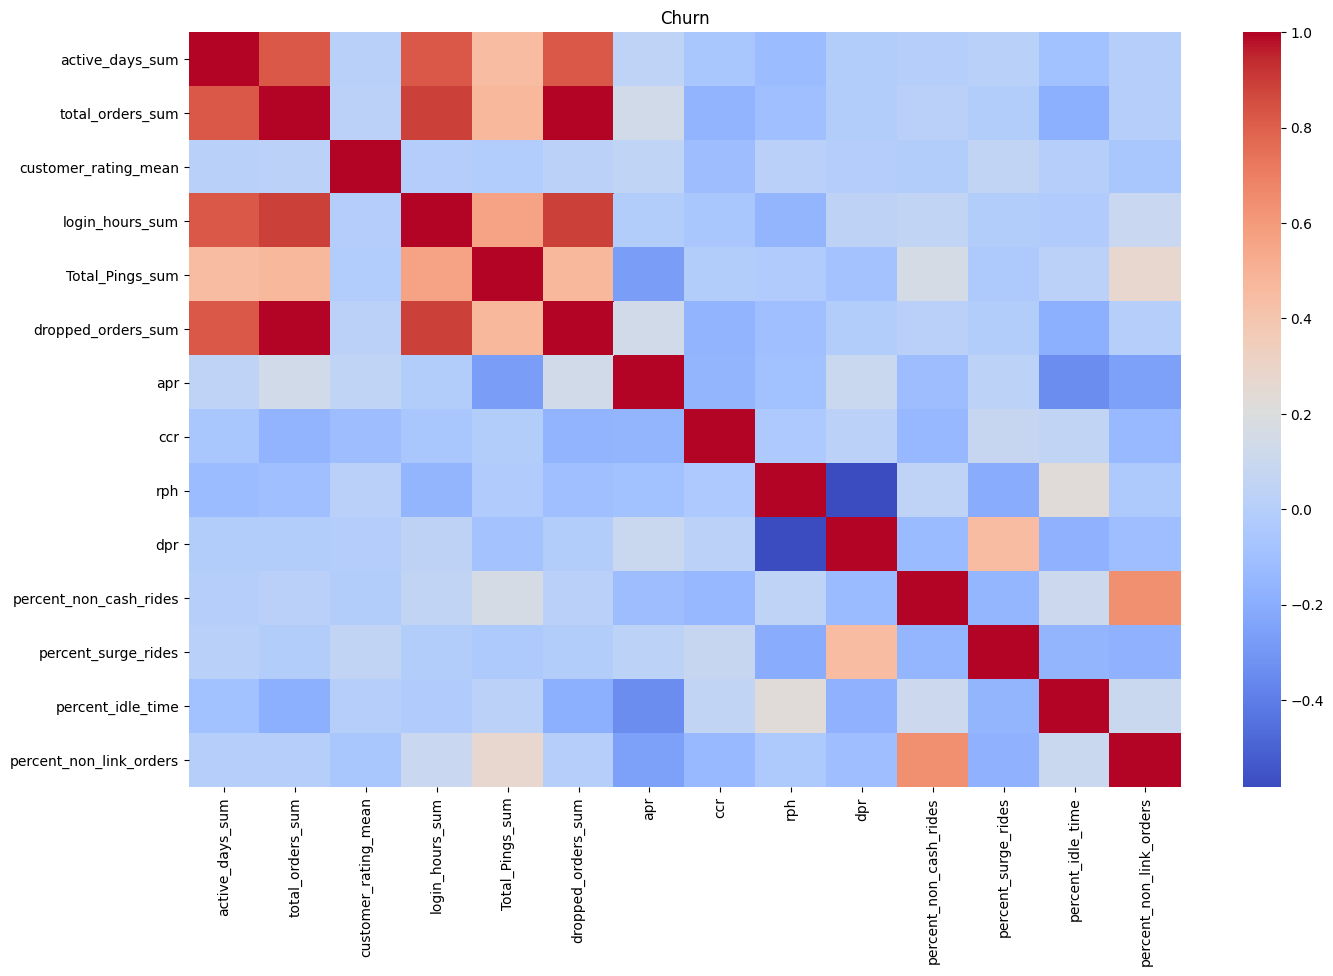

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 10))
fig.set_dpi(100)
ax = sns.heatmap(df_final[df_final['churn']==1][['active_days_sum','total_orders_sum','customer_rating_mean','login_hours_sum','Total_Pings_sum','dropped_orders_sum',
                   'apr','ccr','rph','dpr','percent_non_cash_rides','percent_surge_rides','percent_idle_time','percent_non_link_orders']].corr(), ax = axes, cmap='coolwarm')
ax.set_title('Churn')

In [16]:
pip install xgboost

  Using cached xgboost-1.6.0-py3-none-manylinux2014_x86_64.whl (193.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [90]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import time

scaler = MinMaxScaler()
tmp = scaler.fit_transform(df_final.drop(['captain_id','churn'], axis=1))
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(tmp, df_final['churn'], test_size=test_size, random_state=seed)

tst = scaler.fit_transform(df_test.drop(['captain_id','churn'], axis=1))

tst_2 = scaler.fit_transform(df_test_2.drop(['captain_id','churn'], axis=1))

In [93]:
##XGBoost

# fit model no training data
model = XGBClassifier(learning_rate =0.1,
                         n_estimators=100,
                         max_depth=4,
                         min_child_weight=1,
                         gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.3,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1,
                         seed=29)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.40%


In [94]:
## Randome Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


rfc = RandomForestClassifier(bootstrap=True,
                             n_estimators=100,
                             max_depth=4,
                             max_features=0.3, 
                             min_samples_leaf = 4,
                             min_samples_split=2,
                             max_leaf_nodes=None,
                             criterion = 'entropy', 
                             oob_score = True, 
                             n_jobs = -1,
                             random_state = 29)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 67.11
Time consumed for training: 0.383 seconds
Time consumed for prediction: 0.05848 seconds


<AxesSubplot:>

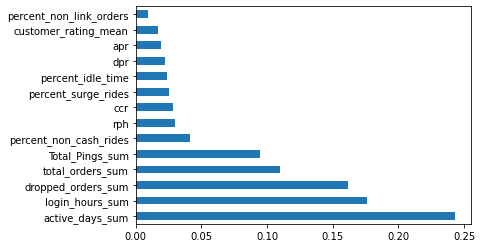

In [95]:
feature_scores = pd.Series(rfc.feature_importances_, index=df_final.columns.drop(['captain_id','churn'])).sort_values(ascending=False)
feature_scores.plot(kind='barh')

In [63]:
confusion_matrix(y_test, preds)

array([[771, 217],
       [289, 327]])

In [64]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       988
           1       0.60      0.53      0.56       616

    accuracy                           0.68      1604
   macro avg       0.66      0.66      0.66      1604
weighted avg       0.68      0.68      0.68      1604



In [96]:
preds = rfc.predict(tst)
acc_rfc = (preds == df_test['churn']).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 82.35


In [97]:
preds = rfc.predict(tst_2)
acc_rfc = (preds == df_test_2['churn']).sum().astype(float) / len(preds)*100
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 82.20


In [219]:
parameters = {
    "bootstrap":[True, False],
    "n_estimators":[5,10,50,100,200],
    "max_depth":[2,4,8,16,32,None],
    "max_features":[0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10]
}

rfc = RandomForestClassifier()
cv = GridSearchCV(rfc, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
parameters.best_params_

AttributeError: 'dict' object has no attribute 'best_params_'

In [ ]:
parameters.best_params_

In [220]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [98]:
#display(cv)

In [105]:
x = df_ltr[df_ltr['week']==4].drop('week', axis=1).merge(df_rides[df_rides['week'].isin([5,6])], how = 'left', on = 'captain_id')

In [106]:
x = x.groupby(['captain_id']).agg('sum').reset_index()
x.head()

,captain_id,ltr,active_days,link_orders,delivery_orders,total_orders,customer_rating,ride_duration,ride_distance,non_cash_rides,surge_rides,week
0,59dce792fefbc7ce33a1a29e,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0
1,59e5b0eb2298384a130df985,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0
2,59e6ee181ef4c6983658b330,47.0,3.0,16.0,4.0,20.0,4.333333,212.098450,90.7430,5.0,7.0,5.0
3,59ec764b0acca92a80791855,15.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0
4,59ef0509dd772a70fdd57b1b,86.0,6.0,12.0,1.0,13.0,8.166667,212.165683,53.6106,3.0,1.0,11.0


In [107]:
x.shape

(4601, 12)

In [110]:
x[x['total_orders']==0]

,captain_id,ltr,active_days,link_orders,delivery_orders,total_orders,customer_rating,ride_duration,ride_distance,non_cash_rides,surge_rides,week
0,59dce792fefbc7ce33a1a29e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59e5b0eb2298384a130df985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59ec764b0acca92a80791855,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,59f49745d2fb657d8d5cdf6d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,59f829389e8ef95b572679ff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4590,61f66a6f6916b85a6faf1217,103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4591,61f670dd794e424cd04b10db,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4592,61f67966ebef823dd0294863,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4595,61f6805d794e42da2f4b1cb6,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [382]:
##Decision Tree

from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
#print('Decision Tree Classifier Created')
y_pred = dtree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.38%
